<a href="https://colab.research.google.com/github/judyschen/Profolio/blob/main/ML_Final_Predictive_Analytics_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation
First, we need to load and preprocess the data:

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
!git clone https://github.com/judyschen/Profolio.git

Cloning into 'Profolio'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 33 (delta 7), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (33/33), 4.53 MiB | 2.75 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [4]:
# Load the data
train_data = pd.read_csv('Profolio/(Multi-Class Prediction)train.csv')
test_data = pd.read_csv('Profolio/(Multi-Class Prediction)test.csv')

In [5]:
train_data.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [ ]:
test_data.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7905,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,7906,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,7907,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,7908,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,7909,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0


This is a multi-class classification problem, with one class for each possible patient outcome.

Status_C: The patient is alive (censored) at the end of the study period.
Status_CL: The patient is alive due to a liver transplant.
Status_D: The patient is deceased.
Each of these outcomes is mutually exclusive and represents a different class that the model needs to predict.

In [ ]:
# Function to preprocess the data
def preprocess_data(df, train=True, encoder=None, scaler=None):
    # Separating features and target if it's training data
    if train:
        X = df.drop(['Status', 'id'], axis=1)  # Drop 'id' and 'Status' for training data
        y = df['Status']
    else:
        X = df.drop(['id'], axis=1)  # Drop only 'id' for test data

    # Identify categorical columns
    categorical_cols = X.select_dtypes(include=['object']).columns

    # One-hot encoding for categorical variables
    if train:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        X_encoded = encoder.fit_transform(X[categorical_cols])
    else:
        X_encoded = encoder.transform(X[categorical_cols])

    X_encoded = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))
    X = X.drop(categorical_cols, axis=1)
    X = pd.concat([X, X_encoded], axis=1)

    # Standardize the numerical features
    if train:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)

    if train:
        return X, y, encoder, scaler
    else:
        return X

In [ ]:
# Preprocessing the training data
X_train, y_train, encoder, scaler = preprocess_data(train_data, train=True)

# Convert target variable 'Status' into numerical form
y_train = pd.get_dummies(y_train)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# 1. Logistic Regression Model

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

# One-vs-Rest Logistic Regression Model
ovr_logreg = OneVsRestClassifier(LogisticRegression(max_iter=2000))
ovr_logreg.fit(X_train, y_train)
ovr_logreg_preds = ovr_logreg.predict_proba(X_val)
print("One-vs-Rest Logistic Regression Log Loss:", log_loss(y_val, ovr_logreg_preds))

One-vs-Rest Logistic Regression Log Loss: 0.5299581153185046


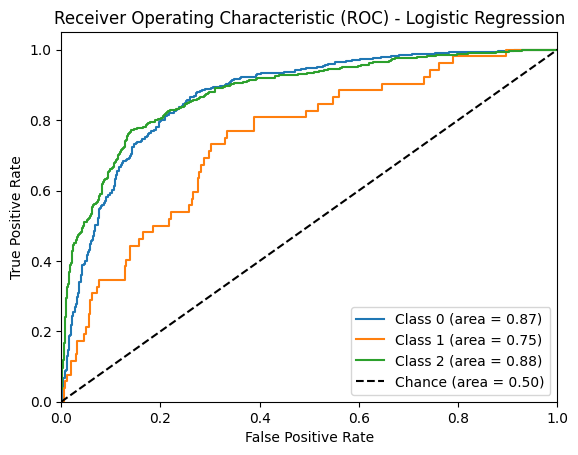

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming ovr_logreg is your fitted OneVsRestClassifier with LogisticRegression
# Predict probabilities for each class
logreg_probs = ovr_logreg.predict_proba(X_val)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val.iloc[:, i], logreg_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance (area = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


## Cross-Validation for Logistic Regression

In [ ]:
from sklearn.model_selection import cross_val_score

# Logistic Regression with OneVsRestClassifier
ovr_logreg = OneVsRestClassifier(LogisticRegression(max_iter=2000))

# Perform cross-validation
logreg_scores = cross_val_score(ovr_logreg, X_train, y_train, cv=5, scoring='neg_log_loss')
print("Logistic Regression CV Log Loss:", -logreg_scores.mean())

Logistic Regression CV Log Loss: 0.5297016402106406


Logistic Regression Log Loss is 0.529, and cross-validation results were similar.

# 2. Random Forest Model

In [ ]:
import numpy as np
# Random Forest Model
rf = RandomForestClassifier(n_estimators=200, max_depth = 10)
rf.fit(X_train, y_train)
# Predict on validation set with Random Forest
rf_preds = rf.predict_proba(X_val)

# Reshape predictions to a 2D array
# rf_preds is a list of arrays, where each array is of shape (n_samples, 2)
# We need to extract the probabilities for the positive class (index 1)
rf_preds_reshaped = np.array([pred[:, 1] for pred in rf_preds]).T

# Calculate log loss
print("Random Forest Log Loss:", log_loss(y_val, rf_preds_reshaped))

Random Forest Log Loss: 0.4670087804359967


(1581, 3)


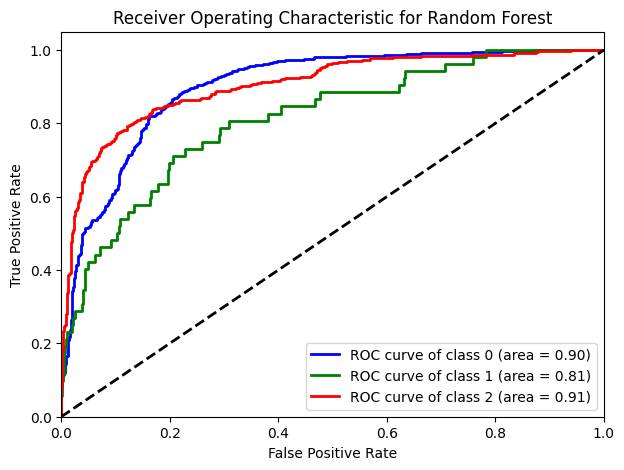

In [ ]:
import numpy as np

# Assuming rf_probs is a list of 3 arrays, each with shape (1581, 2)
# We need to extract the second column for each class since it contains the probabilities for the positive class
rf_probs_reshaped = np.array([cls_probs[:, 1] for cls_probs in rf_probs]).T

# Check the new shape
print(rf_probs_reshaped.shape)  # Should be (1581, 3)

# Now we can calculate the ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val.iloc[:, i], rf_probs_reshaped[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(7, 5))
colors = ['blue', 'green', 'red']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Random Forest')
plt.legend(loc="lower right")
plt.show()


## Cross-Validation for Random Forest

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import numpy as np

# Custom scorer function
def multiclass_log_loss(y_true, y_pred):
    # Reshape predictions
    y_pred_reshaped = np.array([prob[:, 1] for prob in y_pred]).T
    return log_loss(y_true, y_pred_reshaped)

# Custom log loss scorer for multi-class
log_loss_scorer = make_scorer(multiclass_log_loss, greater_is_better=False, needs_proba=True)

# Random Forest Model
rf = RandomForestClassifier(n_estimators=200, max_depth=10)

# Perform cross-validation using the custom scorer
rf_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring=log_loss_scorer)
print("Random Forest CV Log Loss:", -rf_scores.mean())


Random Forest CV Log Loss: 0.4694050284059421


I  adjusted the model with n_estimators=200 and max_depth=10. The resulting Log Loss is 0.469, and the performance in cross-validation is similarly effective.

# 3. Neural Network

In [ ]:
# Neural Network Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.fit(X_train, y_train, epochs=10, batch_size=40, validation_data=(X_val, y_val))

# Predict on the validation set using the neural network
nn_preds = model.predict(X_val)

# Calculate log loss
nn_log_loss = log_loss(y_val, nn_preds)
print("Neural Network Log Loss:", nn_log_loss)


Epoch 1/10
159/159 [==============================] - 1s 4ms/step - loss: 0.5996 - val_loss: 0.5390
Epoch 2/10
159/159 [==============================] - 0s 3ms/step - loss: 0.5130 - val_loss: 0.5134
Epoch 3/10
159/159 [==============================] - 0s 3ms/step - loss: 0.4978 - val_loss: 0.5154
Epoch 4/10
159/159 [==============================] - 0s 3ms/step - loss: 0.4901 - val_loss: 0.5054
Epoch 5/10
159/159 [==============================] - 1s 3ms/step - loss: 0.4799 - val_loss: 0.4982
Epoch 6/10
159/159 [==============================] - 0s 2ms/step - loss: 0.4696 - val_loss: 0.5152
Epoch 7/10
159/159 [==============================] - 0s 2ms/step - loss: 0.4645 - val_loss: 0.4920
Epoch 8/10
159/159 [==============================] - 1s 4ms/step - loss: 0.4570 - val_loss: 0.5057
Epoch 9/10
159/159 [==============================] - 1s 4ms/step - loss: 0.4511 - val_loss: 0.4928
Epoch 10/10
50/50 [==============================] - 0s 2ms/step
Neural Network Log Loss: 0.49921358

50/50 [==============================] - 0s 2ms/step


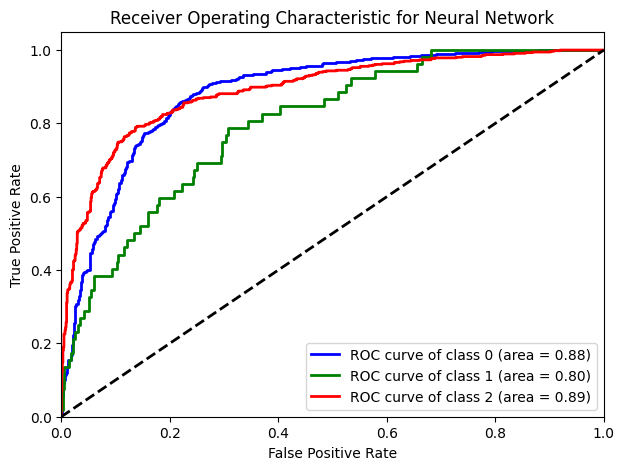

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming model is your fitted neural network and X_val is your validation dataset
nn_probs = model.predict(X_val)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_val.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val.iloc[:, i], nn_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(7, 5))
colors = ['blue', 'green', 'red']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Neural Network')
plt.legend(loc="lower right")
plt.show()


## Cross-Validation for Neural Network:
For the Neural Network, we have to manually split the data into folds and train a new model on each fold. Here we use 5-fold cross-validation:

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import log_loss

kf = KFold(n_splits=5)
nn_log_losses = []

for train_index, val_index in kf.split(X_train):
    # Split data
    X_train_kf, X_val_kf = X_train[train_index], X_train[val_index]
    y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]

    # Define the model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy')

    # Train the model
    model.fit(X_train_kf, y_train_kf, epochs=10, batch_size=40, verbose=0)

    # Predict on the validation set
    nn_preds_kf = model.predict(X_val_kf)

    # Calculate log loss
    nn_log_loss_kf = log_loss(y_val_kf, nn_preds_kf)
    nn_log_losses.append(nn_log_loss_kf)

# Average log loss across all folds
print("Neural Network CV Log Loss:", np.mean(nn_log_losses))


40/40 [==============================] - 0s 2ms/step
Neural Network CV Log Loss: 0.5084053213277253


The Neural Network's Log Loss is 0.50, and the cross-validation results showed a similar performance.

# Prediction and Export

After evaluating three models, it's evident that the Random Forest model performed the best. Consequently, we will use the Random Forest model to make predictions on the test set.

In [ ]:
# Choose the Random Forest model based on log loss and make predictions on the test set
# Fitting the Random Forest model on the entire training data
rf = RandomForestClassifier(n_estimators=200, max_depth=10)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200)

In [ ]:
# Preprocess the test data
X_test = preprocess_data(test_data, train=False, encoder=encoder, scaler=scaler)

# Making predictions on the test set
rf_test_preds = rf.predict_proba(X_test)

In [ ]:
# Format predictions for submission
test_predictions = [prob[:, 1] for prob in rf_test_preds]
test_predictions_df = pd.DataFrame(test_predictions).T
test_predictions_df.columns = ['Status_C', 'Status_CL', 'Status_D']
submission = pd.concat([test_data['id'], test_predictions_df], axis=1)

# Save the submission file
submission.to_csv('submission.csv', index=False)